In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import sqlite3

In [2]:
news = pd.read_csv('train.csv')

In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [4]:
news

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [5]:
news.dropna (how='all') 

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [6]:
len(news.author.unique ())

4202

In [24]:
def check_user_in_base(user_name):
    try:
        sqlite_connection = sqlite3.connect('confidence.db')
        cursor = sqlite_connection.cursor()
        print("Подключен к SQLite")

        info = cursor.execute('SELECT * FROM authors WHERE name=?', (user_name, )).fetchone()
        #Если запрос вернул 0 строк, то...
        cursor.close()
        if info != None:
            return True
                    
        else:
            return False

    except sqlite3.Error as error:
        print("Ошибка при работе с SQLite", error)
    finally:
        if sqlite_connection:
            sqlite_connection.close()
            print("Соединение с SQLite закрыто")

In [17]:
def add_user(id_au, name_au, tr_nw, fa_news):
    try:
        sqlite_connection = sqlite3.connect('confidence.db')
        cursor = sqlite_connection.cursor()
        print("Подключен к SQLite")

        sqlite_insert_with_param = """INSERT INTO authors
                                (id_author, name, true_news, fake_news)
                                VALUES (?, ?, ?, ?);"""

        data_tuple = (id_au, name_au, tr_nw, fa_news)
        cursor.execute(sqlite_insert_with_param, data_tuple)
        sqlite_connection.commit()
        print("Переменные Python успешно вставлены в таблицу authors")

        cursor.close()

    except sqlite3.Error as error:
        print("Ошибка при работе с SQLite", error)
    finally:
        if sqlite_connection:
            sqlite_connection.close()
            print("Соединение с SQLite закрыто")

In [9]:
book = dict()
for i in range(len(news)):
    if news.iloc[i][2] not in book:
        if news.iloc[i][4] == 0:
            book[news.iloc[i][2]] = [1, 0]
        else:
            book[news.iloc[i][2]] = [0, 1]
    else:
        book[news.iloc[i][2]][news.iloc[i][4]] += 1

In [11]:
sorted_book = sorted(book.items(), key=lambda x:x[1][1])
sorted_book.reverse()
print(sorted_book[2:12])

[('Pakalert', [0, 86]), ('Eddy Lavine', [0, 85]), ('Starkman', [0, 84]), ('Gillian', [0, 82]), ('Alex Ansary', [0, 82]), ('Editor', [0, 81]), ('noreply@blogger.com (Alexander Light)', [0, 80]), ('Dave Hodges', [0, 77]), ('Anonymous', [0, 77]), ('IWB', [0, 75])]


In [26]:
sorted_book = sorted(book.items(), key=lambda x:x[1][0])
sorted_book.reverse()
print(sorted_book[:10])
unreliable = sorted_book[:10]

[('Pam Key', [242, 1]), ('Jerome Hudson', [166, 0]), ('Charlie Spiering', [141, 0]), ('John Hayward', [140, 0]), ('Katherine Rodriguez', [124, 0]), ('Warner Todd Huston', [122, 0]), ('Ian Hanchett', [119, 0]), ('Breitbart News', [118, 0]), ('Daniel Nussbaum', [112, 0]), ('AWR Hawkins', [107, 0])]


In [28]:
nam = []
cnt = []
for i in unreliable:
    nam.append(i[0])
    cnt.append(int(i[1][0]))

<BarContainer object of 10 artists>

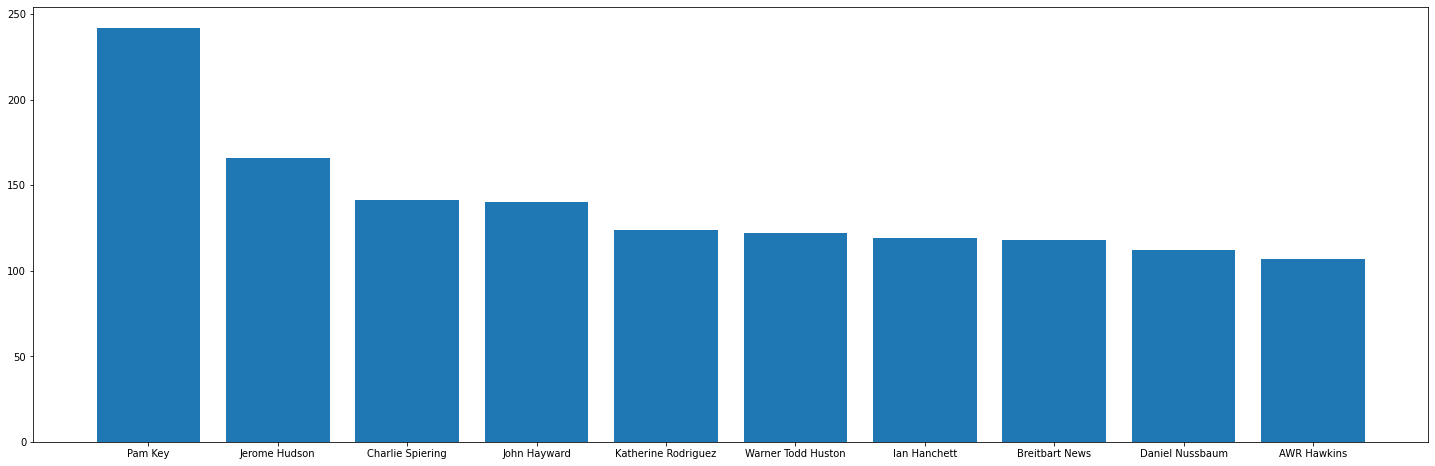

In [45]:
fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot()

ax.bar(nam, cnt)

In [46]:
number = 1
for person in book:
    if person != '':
        add_user(number, person, book[person][1], book[person][0])
        number += 1

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Ошибка при работе с SQLite NOT NULL constraint failed: authors.name
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соед

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблиц

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен

Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблиц

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблиц

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблиц

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблиц

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблиц

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit

Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLite закрыто
Подключен к SQLite
Переменные Python успешно вставлены в таблицу authors
Соединение с SQLit